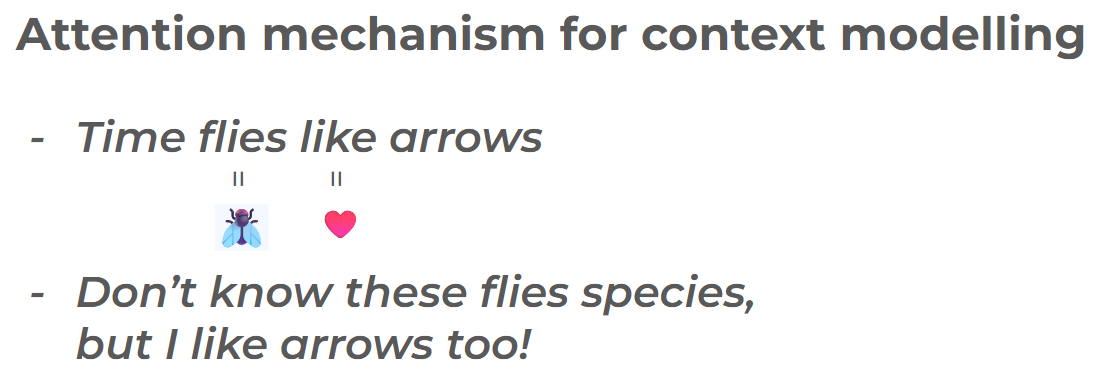

In [1]:
import torch
import torch.nn as nn
import random
import numpy as np

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Import our modules
from dataset import TextClassificationDataset
from models import create_model
from training import create_dataloaders, train_model_simple

In [2]:
print("\nCreating Dataset with Train/Val Split")
print("-" * 40)

dataset = TextClassificationDataset(
    csv_path="movie_reviews.csv",
    min_vocab_freq=2,
    test_size=0.2,
    random_state=42
)


Creating Dataset with Train/Val Split
----------------------------------------
Loaded 150 samples from movie_reviews.csv
Dataset loaded: 150 total samples
Train: 120 samples
Validation: 30 samples
Vocabulary size: 133
Train label distribution: Counter({0: 40, 2: 40, 1: 40})
Val label distribution: Counter({0: 10, 2: 10, 1: 10})
Sample vocab: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', 'absolutely', 'acceptable', 'acting', 'actors', 'adequate', 'adequately', 'amazing', 'and', 'any', 'attention']


In [3]:
dataset.print_sample_data()


Sample training data (first 5 examples):
------------------------------------------------------------
Example 1:
  Text: 'terrible acting ruining what could have been good'
  Label: 0 (Negative)
  Encoded: [113, 7, 1, 129, 1, 1, 1, 61]
  Length: 8 tokens

Example 2:
  Text: 'typical movie following predictable formula'
  Label: 2 (Neutral)
  Encoded: [121, 80, 1, 96, 60]
  Length: 5 tokens

Example 3:
  Text: 'remarkable film showcasing incredible talent and creativity'
  Label: 1 (Positive)
  Encoded: [102, 58, 104, 64, 111, 12, 1]
  Length: 7 tokens

Example 4:
  Text: 'boring film with no redeeming qualities at all'
  Label: 0 (Negative)
  Encoded: [19, 58, 130, 83, 101, 98, 1, 1]
  Length: 8 tokens

Example 5:
  Text: 'exceptional cinema that redefined my expectations completely'
  Label: 1 (Positive)
  Encoded: [51, 26, 114, 1, 81, 53, 31]
  Length: 7 tokens



In [4]:
dataset.idx_to_word

{0: '[PAD]',
 1: '[UNK]',
 2: '[CLS]',
 3: '[SEP]',
 4: '[MASK]',
 5: 'absolutely',
 6: 'acceptable',
 7: 'acting',
 8: 'actors',
 9: 'adequate',
 10: 'adequately',
 11: 'amazing',
 12: 'and',
 13: 'any',
 14: 'attention',
 15: 'audience',
 16: 'average',
 17: 'awful',
 18: 'basic',
 19: 'boring',
 20: 'brilliant',
 21: 'but',
 22: 'by',
 23: 'cast',
 24: 'character',
 25: 'characters',
 26: 'cinema',
 27: 'cinematic',
 28: 'cinematography',
 29: 'combined',
 30: 'competent',
 31: 'completely',
 32: 'creating',
 33: 'decent',
 34: 'deliver',
 35: 'delivered',
 36: 'depth',
 37: 'detail',
 38: 'development',
 39: 'dialogue',
 40: 'direction',
 41: 'disappointing',
 42: 'drama',
 43: 'editing',
 44: 'elements',
 45: 'emotional',
 46: 'engaged',
 47: 'entertainment',
 48: 'every',
 49: 'everywhere',
 50: 'excellent',
 51: 'exceptional',
 52: 'execution',
 53: 'expectations',
 54: 'experience',
 55: 'failing',
 56: 'fair',
 57: 'fantastic',
 58: 'film',
 59: 'for',
 60: 'formula',
 61: 'go

In [5]:
# Get data and create loaders
train_texts, train_labels = dataset.get_train_data(binary=True)
val_texts, val_labels = dataset.get_val_data(binary=True)
train_loader, val_loader = create_dataloaders(
    train_texts, train_labels, val_texts, val_labels, 
    batch_size=8, shuffle_train=True
)

print(f"Training: {len(train_texts)} samples")
print(f"Validation: {len(val_texts)} samples")
print(f"Vocabulary: {dataset.vocab_size} words")

Training: 120 samples
Validation: 30 samples
Vocabulary: 133 words


# First approach: naive bag-of-words classifier

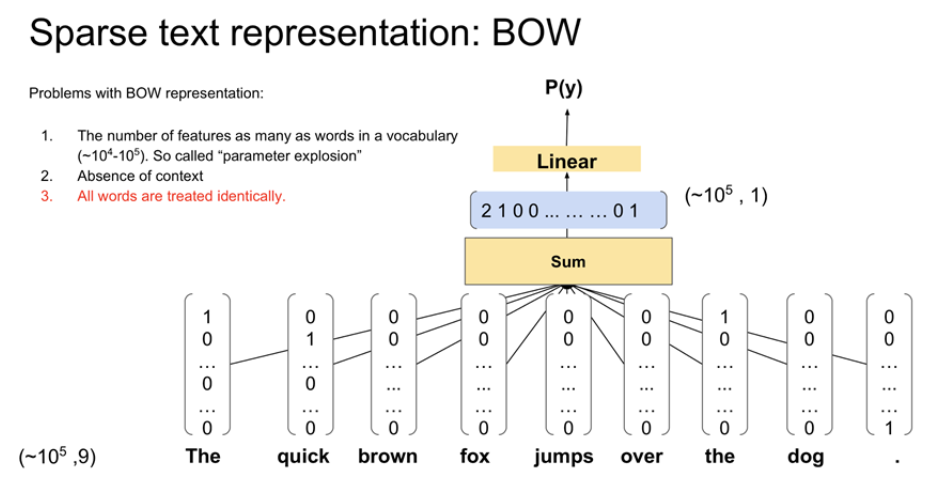

In [6]:
def test_sample_prediction(model, val_loader):
    """Test model on a sample and show prediction"""
    model.eval()
    with torch.no_grad():
        sample_batch = next(iter(val_loader))
        sample_texts, sample_labels = sample_batch
        
        logits = model(sample_texts[:1])
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probabilities.max().item()
        actual = sample_labels[0].item()
        
        print(f"Sample Text: {sample_texts[0]}")
        print(f"Sample Prediction: {prediction} (confidence: {confidence:.3f})")
        print(f"Actual Label: {actual} ({'CORRECT' if prediction == actual else 'WRONG'})")

In [7]:
results = {}


print("\nMODEL 0: BAG OF WORDS")
print("=" * 40)
model_0 = create_model('bow', dataset.vocab_size, num_classes=2)
results['Bag of Words'] = train_model_simple(model_0, train_loader, val_loader)
test_sample_prediction(model_0, val_loader)


MODEL 0: BAG OF WORDS
Model 0 created: 133 vocab -> 2 classes
Training for 6 epochs with lr=0.001
Epoch 0: Train Loss=0.6749, Train Acc=59.2% | Val Loss=0.6245, Val Acc=70.0%
Epoch 1: Train Loss=0.6486, Train Acc=69.2% | Val Loss=0.6102, Val Acc=70.0%
Epoch 2: Train Loss=0.6258, Train Acc=68.3% | Val Loss=0.5974, Val Acc=70.0%
Epoch 3: Train Loss=0.6051, Train Acc=70.0% | Val Loss=0.5866, Val Acc=70.0%
Epoch 4: Train Loss=0.5857, Train Acc=71.7% | Val Loss=0.5767, Val Acc=70.0%
Epoch 5: Train Loss=0.5681, Train Acc=73.3% | Val Loss=0.5669, Val Acc=70.0%
Sample Text: tensor([ 17,  97, 130,   1,  28, 132,   0,   0,   0,   0])
Sample Prediction: 0 (confidence: 0.594)
Actual Label: 0 (CORRECT)


# Second Approach: Utilizing token embeddings

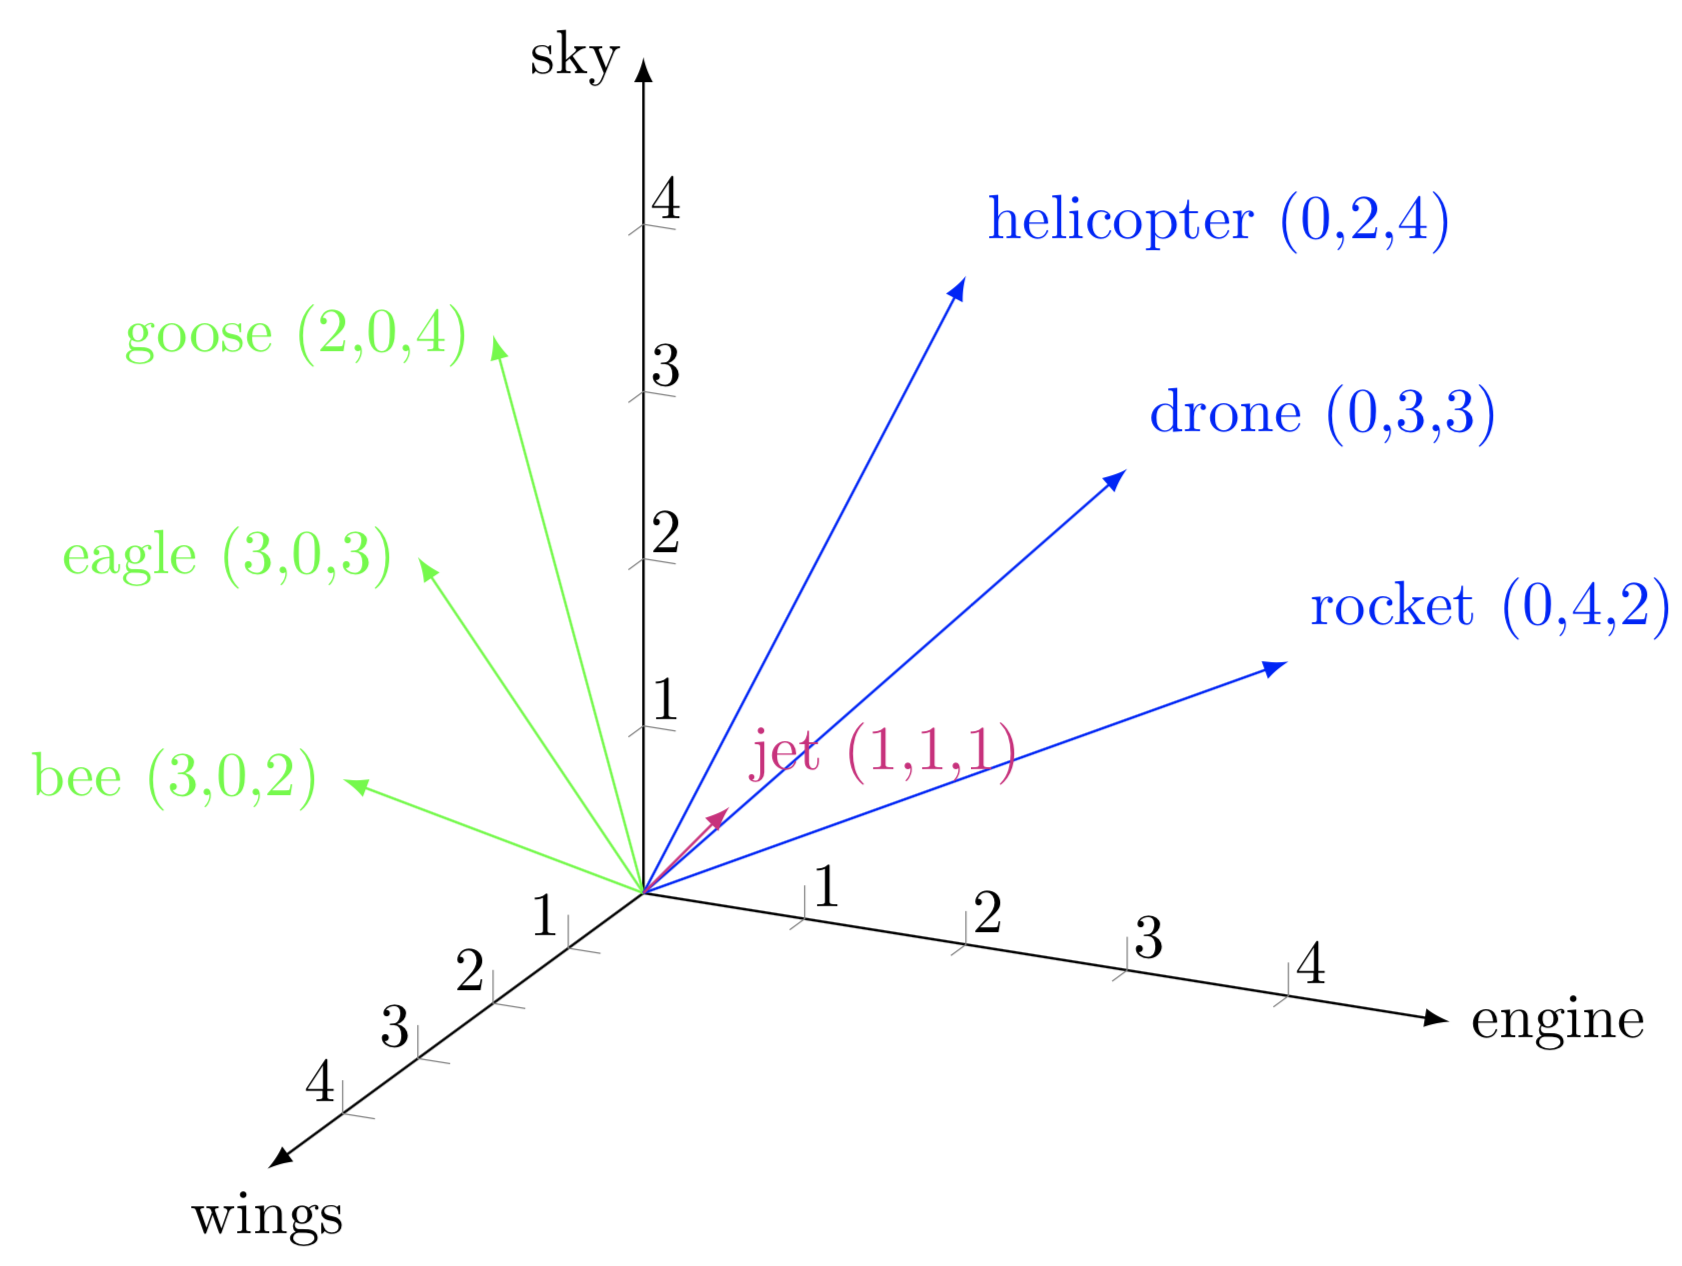

In [8]:
model_1 = create_model('embedding', dataset.vocab_size, embed_dim=64, num_classes=2)
results['Word Embeddings'] = train_model_simple(model_1, train_loader, val_loader)
test_sample_prediction(model_1, val_loader)

Model 1 created: 133 vocab -> 64d embeddings -> 2 classes
Training for 6 epochs with lr=0.001
Epoch 0: Train Loss=0.6253, Train Acc=71.7% | Val Loss=0.6081, Val Acc=73.3%
Epoch 1: Train Loss=0.5965, Train Acc=74.2% | Val Loss=0.5932, Val Acc=73.3%
Epoch 2: Train Loss=0.5744, Train Acc=74.2% | Val Loss=0.5784, Val Acc=73.3%
Epoch 3: Train Loss=0.5516, Train Acc=76.7% | Val Loss=0.5655, Val Acc=73.3%
Epoch 4: Train Loss=0.5317, Train Acc=77.5% | Val Loss=0.5521, Val Acc=73.3%
Epoch 5: Train Loss=0.5110, Train Acc=78.3% | Val Loss=0.5407, Val Acc=73.3%
Sample Text: tensor([ 17,  97, 130,   1,  28, 132,   0,   0,   0,   0])
Sample Prediction: 0 (confidence: 0.692)
Actual Label: 0 (CORRECT)


# The intuition behind self-attention

This part is adapted from Andrej Karpathy's notebook: https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=EDarxEWIRMKq

In [9]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [10]:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels (embedding dim)
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [11]:
print(x[0])

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])


In [12]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [13]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2, atol=1e-3)

True

In [14]:
from torch.nn import functional as F

# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
print(wei)
wei = wei.masked_fill(tril == 0, float('-inf'))
print(wei)
wei = F.softmax(wei, dim=-1)
print(wei)
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-3)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000,

True

In [15]:
# version 4: self-attention!
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)


v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

# Self-attention model

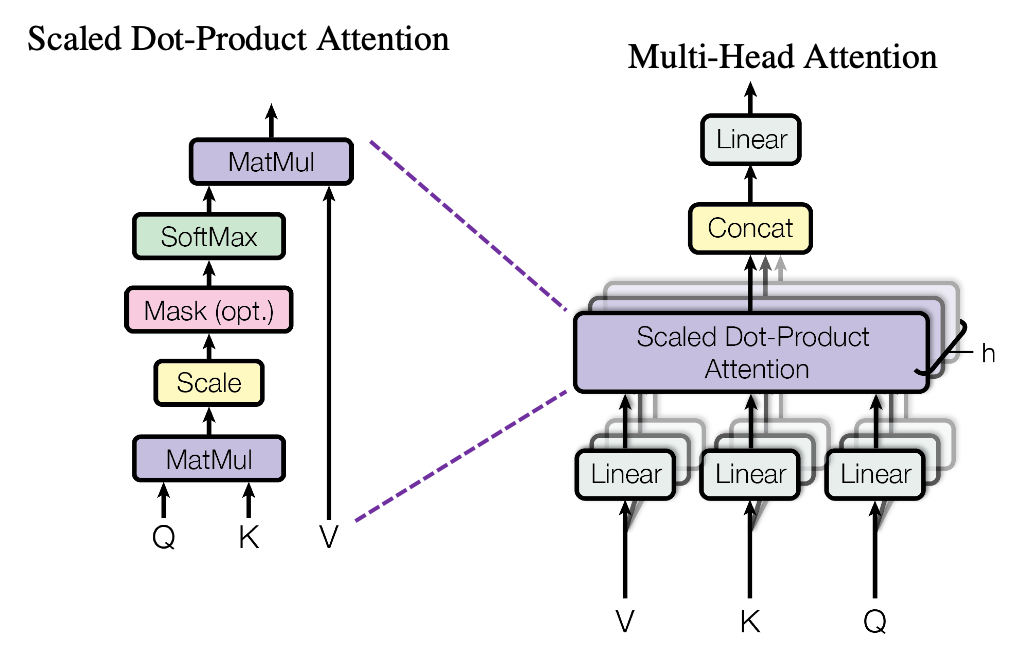

In [16]:
# Model 3: Self-Attention
print("\nMODEL 3: SELF-ATTENTION")
print("=" * 40)
print("THE REVOLUTIONARY IDEA:")
print("- Each word creates its own query!")
print("- Query (Q): What am I looking for?")
print("- Key (K): What do I represent?")
print("- Value (V): What information do I contain?")

model_3 = create_model('self_attention', dataset.vocab_size, embed_dim=64, num_classes=2)
results['Self-Attention'] = train_model_simple(model_3, train_loader, val_loader)
test_sample_prediction(model_3, val_loader)


MODEL 3: SELF-ATTENTION
THE REVOLUTIONARY IDEA:
- Each word creates its own query!
- Query (Q): What am I looking for?
- Key (K): What do I represent?
- Value (V): What information do I contain?
Model 3 created: Self-attention with Q, K, V projections
Training for 6 epochs with lr=0.001
Epoch 0: Train Loss=0.6465, Train Acc=67.5% | Val Loss=0.6034, Val Acc=76.7%
Epoch 1: Train Loss=0.5625, Train Acc=72.5% | Val Loss=0.5631, Val Acc=76.7%
Epoch 2: Train Loss=0.4733, Train Acc=80.0% | Val Loss=0.5268, Val Acc=76.7%
Epoch 3: Train Loss=0.3589, Train Acc=91.7% | Val Loss=0.4839, Val Acc=73.3%
Epoch 4: Train Loss=0.2435, Train Acc=95.0% | Val Loss=0.4547, Val Acc=73.3%
Epoch 5: Train Loss=0.1443, Train Acc=98.3% | Val Loss=0.4817, Val Acc=76.7%
Sample Text: tensor([ 17,  97, 130,   1,  28, 132,   0,   0,   0,   0])
Sample Prediction: 0 (confidence: 0.845)
Actual Label: 0 (CORRECT)


In [17]:
print(results['Self-Attention'])

{'train_loss': 0.14427053332328796, 'train_acc': 98.33333333333333, 'val_loss': 0.48170409351587296, 'val_acc': 76.66666666666667}


# Adding positional encoding

In [18]:
# Model 4: Positional Encoding
print("\nMODEL 4: POSITIONAL ENCODING")
print("=" * 40)
print("- Attention ignores word order!")
print("- Add positional information")
print("- Now model knows about word order")

model_4 = create_model('positional', dataset.vocab_size, embed_dim=64, num_classes=2)
results['+ Positional Encoding'] = train_model_simple(model_4, train_loader, val_loader)
test_sample_prediction(model_4, val_loader)


MODEL 4: POSITIONAL ENCODING
- Attention ignores word order!
- Add positional information
- Now model knows about word order
Model 4 created: Self-attention + positional encoding
Training for 6 epochs with lr=0.001
Epoch 0: Train Loss=0.6667, Train Acc=62.5% | Val Loss=0.6930, Val Acc=66.7%
Epoch 1: Train Loss=0.5870, Train Acc=66.7% | Val Loss=0.5619, Val Acc=76.7%
Epoch 2: Train Loss=0.4995, Train Acc=81.7% | Val Loss=0.5043, Val Acc=76.7%
Epoch 3: Train Loss=0.3943, Train Acc=86.7% | Val Loss=0.4540, Val Acc=76.7%
Epoch 4: Train Loss=0.2865, Train Acc=88.3% | Val Loss=0.4239, Val Acc=76.7%
Epoch 5: Train Loss=0.1821, Train Acc=95.0% | Val Loss=0.4908, Val Acc=73.3%
Sample Text: tensor([ 17,  97, 130,   1,  28, 132,   0,   0,   0,   0])
Sample Prediction: 0 (confidence: 0.942)
Actual Label: 0 (CORRECT)


In [19]:
# Model 5: Multi-Head Attention
print("\nMODEL 5: MULTI-HEAD ATTENTION")
print("=" * 40)
print("- Multiple attention patterns in parallel")
print("- Each head specializes in different relationships")

model_5 = create_model('multi_head', dataset.vocab_size, embed_dim=64,
                      num_heads=4, num_classes=2)
results['Multi-Head Attention'] = train_model_simple(model_5, train_loader, val_loader)
test_sample_prediction(model_5, val_loader)


MODEL 5: MULTI-HEAD ATTENTION
- Multiple attention patterns in parallel
- Each head specializes in different relationships
Model 5 created: Multi-head attention (4 heads)
Training for 6 epochs with lr=0.001
Epoch 0: Train Loss=0.6601, Train Acc=66.7% | Val Loss=0.6335, Val Acc=66.7%
Epoch 1: Train Loss=0.6052, Train Acc=66.7% | Val Loss=0.6057, Val Acc=66.7%
Epoch 2: Train Loss=0.5414, Train Acc=68.3% | Val Loss=0.5540, Val Acc=76.7%
Epoch 3: Train Loss=0.3843, Train Acc=89.2% | Val Loss=0.4447, Val Acc=76.7%
Epoch 4: Train Loss=0.1733, Train Acc=96.7% | Val Loss=0.3593, Val Acc=76.7%
Epoch 5: Train Loss=0.0541, Train Acc=100.0% | Val Loss=0.4130, Val Acc=90.0%
Sample Text: tensor([ 17,  97, 130,   1,  28, 132,   0,   0,   0,   0])
Sample Prediction: 0 (confidence: 0.998)
Actual Label: 0 (CORRECT)


# Full-transformer

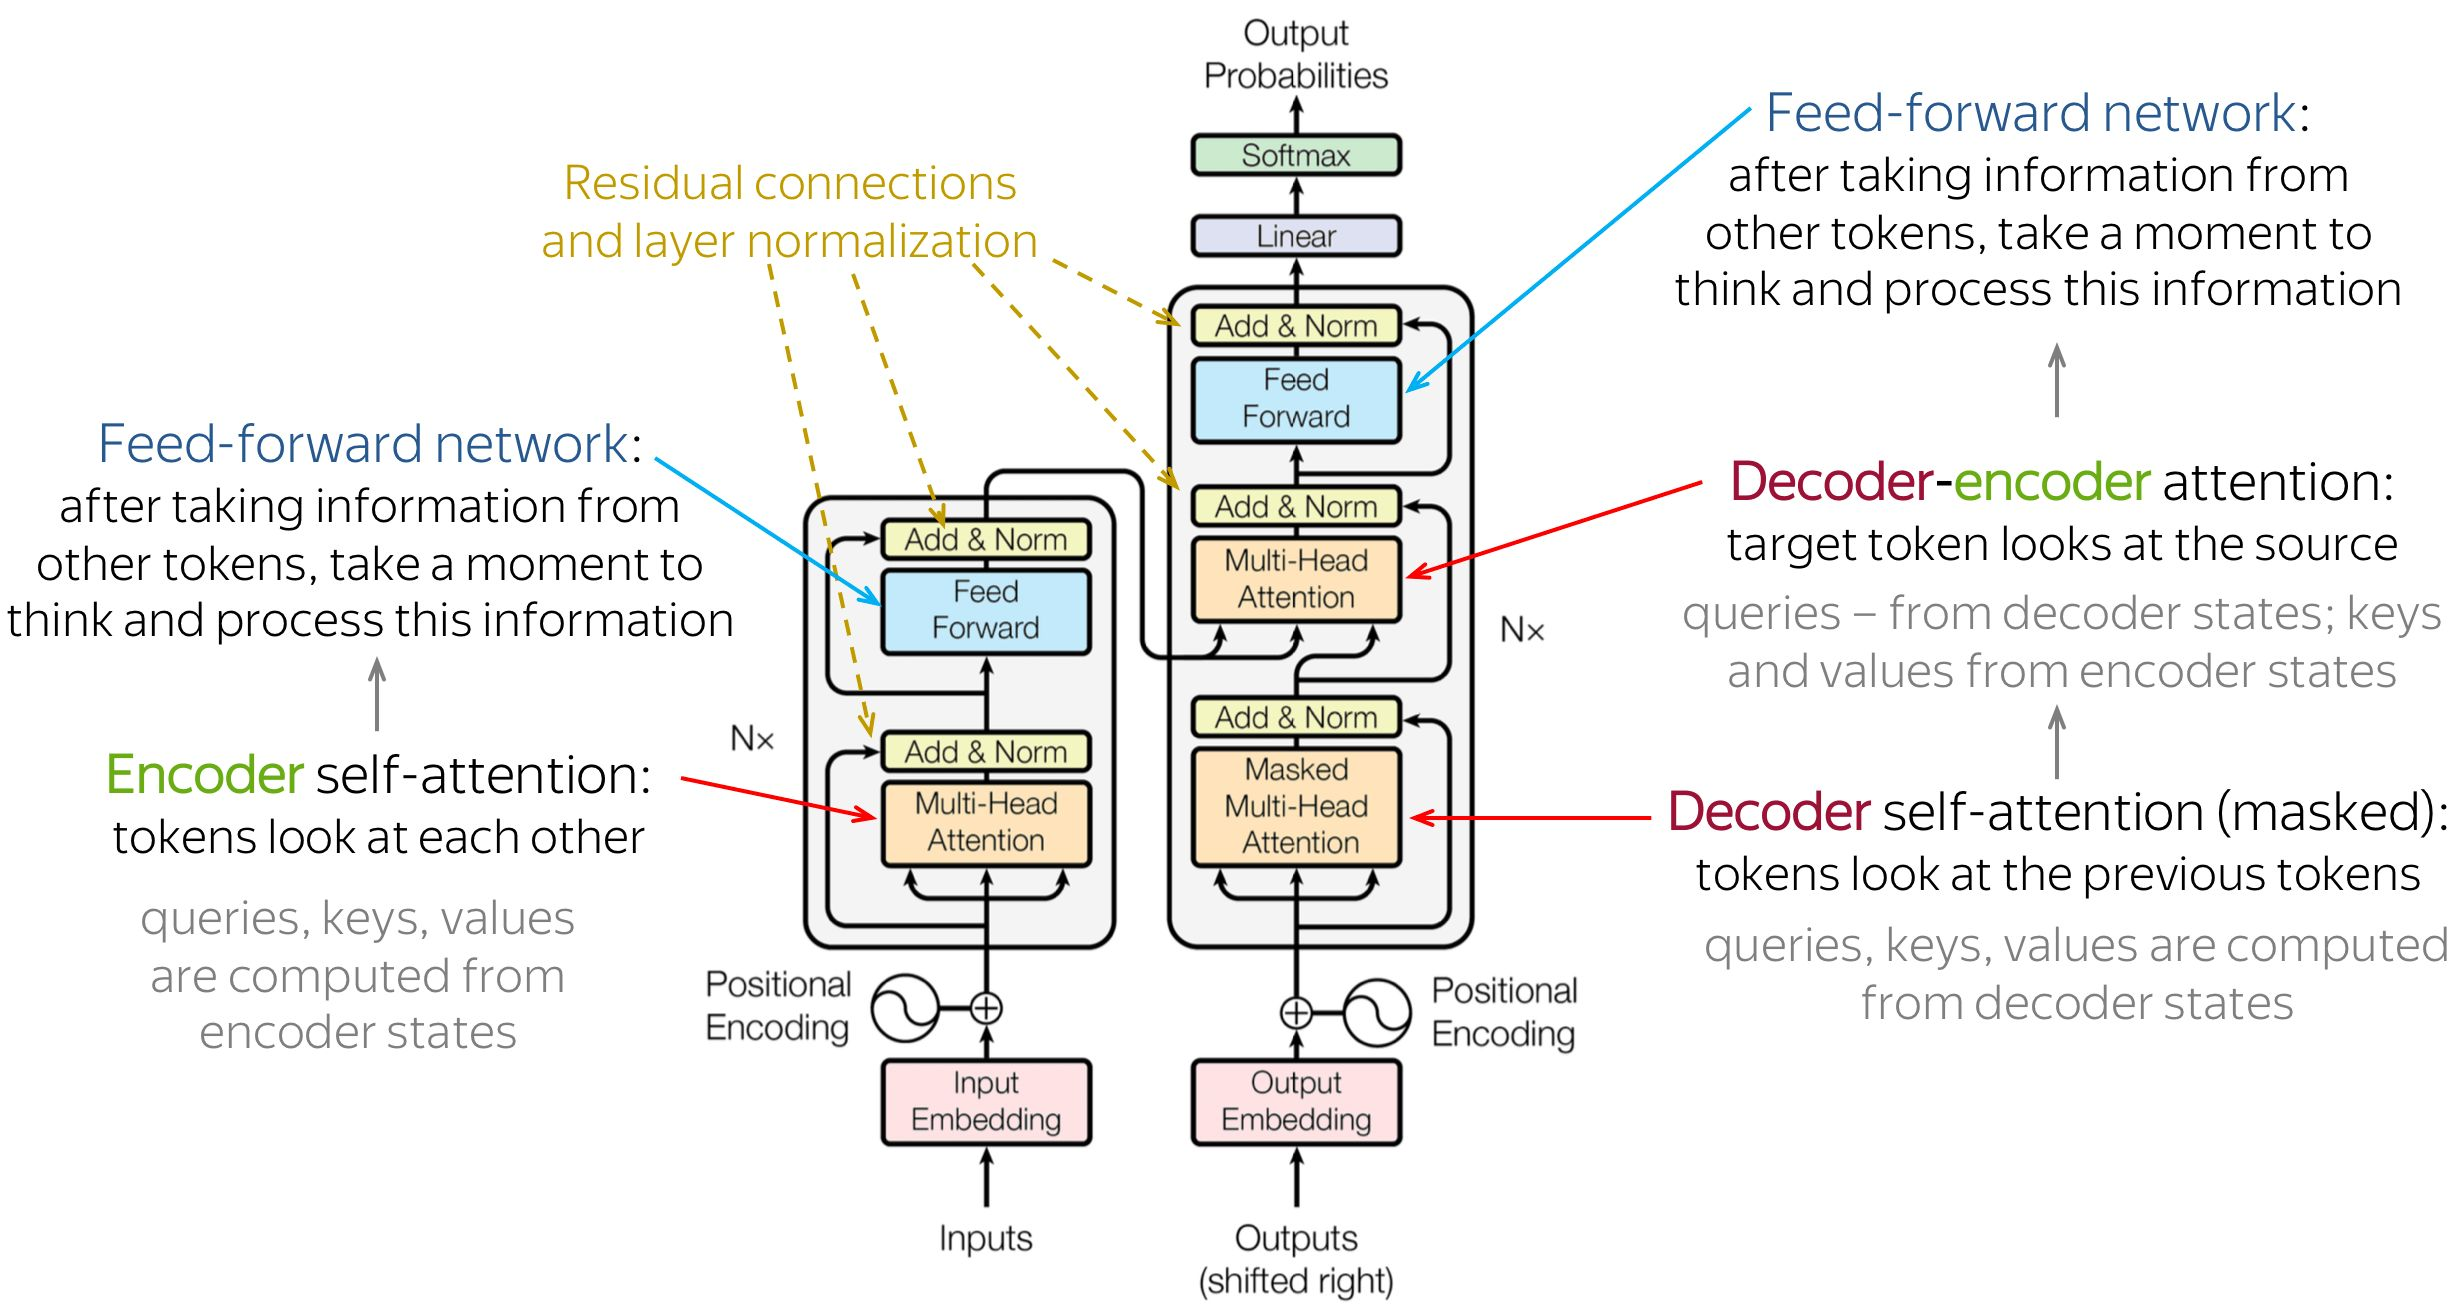

In [20]:
# Model 6: Full Transformer
print("\nMODEL 6: FULL TRANSFORMER")
print("=" * 40)
print("- Multi-head attention + feed-forward")
print("- Residual connections + layer norm")
print("- This is BERT architecture!")

model_6 = create_model('transformer', dataset.vocab_size, embed_dim=64,
                      num_heads=4, num_layers=2, num_classes=2)
results['Full Transformer'] = train_model_simple(model_6, train_loader, val_loader)
test_sample_prediction(model_6, val_loader)


MODEL 6: FULL TRANSFORMER
- Multi-head attention + feed-forward
- Residual connections + layer norm
- This is BERT architecture!
Model 6 created: Full transformer (2 layers, 4 heads)
Training for 6 epochs with lr=0.001
Epoch 0: Train Loss=0.6637, Train Acc=65.8% | Val Loss=0.6104, Val Acc=70.0%
Epoch 1: Train Loss=0.4805, Train Acc=75.0% | Val Loss=0.5310, Val Acc=80.0%
Epoch 2: Train Loss=0.2726, Train Acc=90.8% | Val Loss=0.6494, Val Acc=70.0%
Epoch 3: Train Loss=0.1460, Train Acc=96.7% | Val Loss=0.4548, Val Acc=86.7%
Epoch 4: Train Loss=0.0565, Train Acc=98.3% | Val Loss=0.4155, Val Acc=86.7%
Epoch 5: Train Loss=0.0380, Train Acc=99.2% | Val Loss=0.7724, Val Acc=83.3%
Sample Text: tensor([ 17,  97, 130,   1,  28, 132,   0,   0,   0,   0])
Sample Prediction: 0 (confidence: 0.999)
Actual Label: 0 (CORRECT)


# BERT-like model

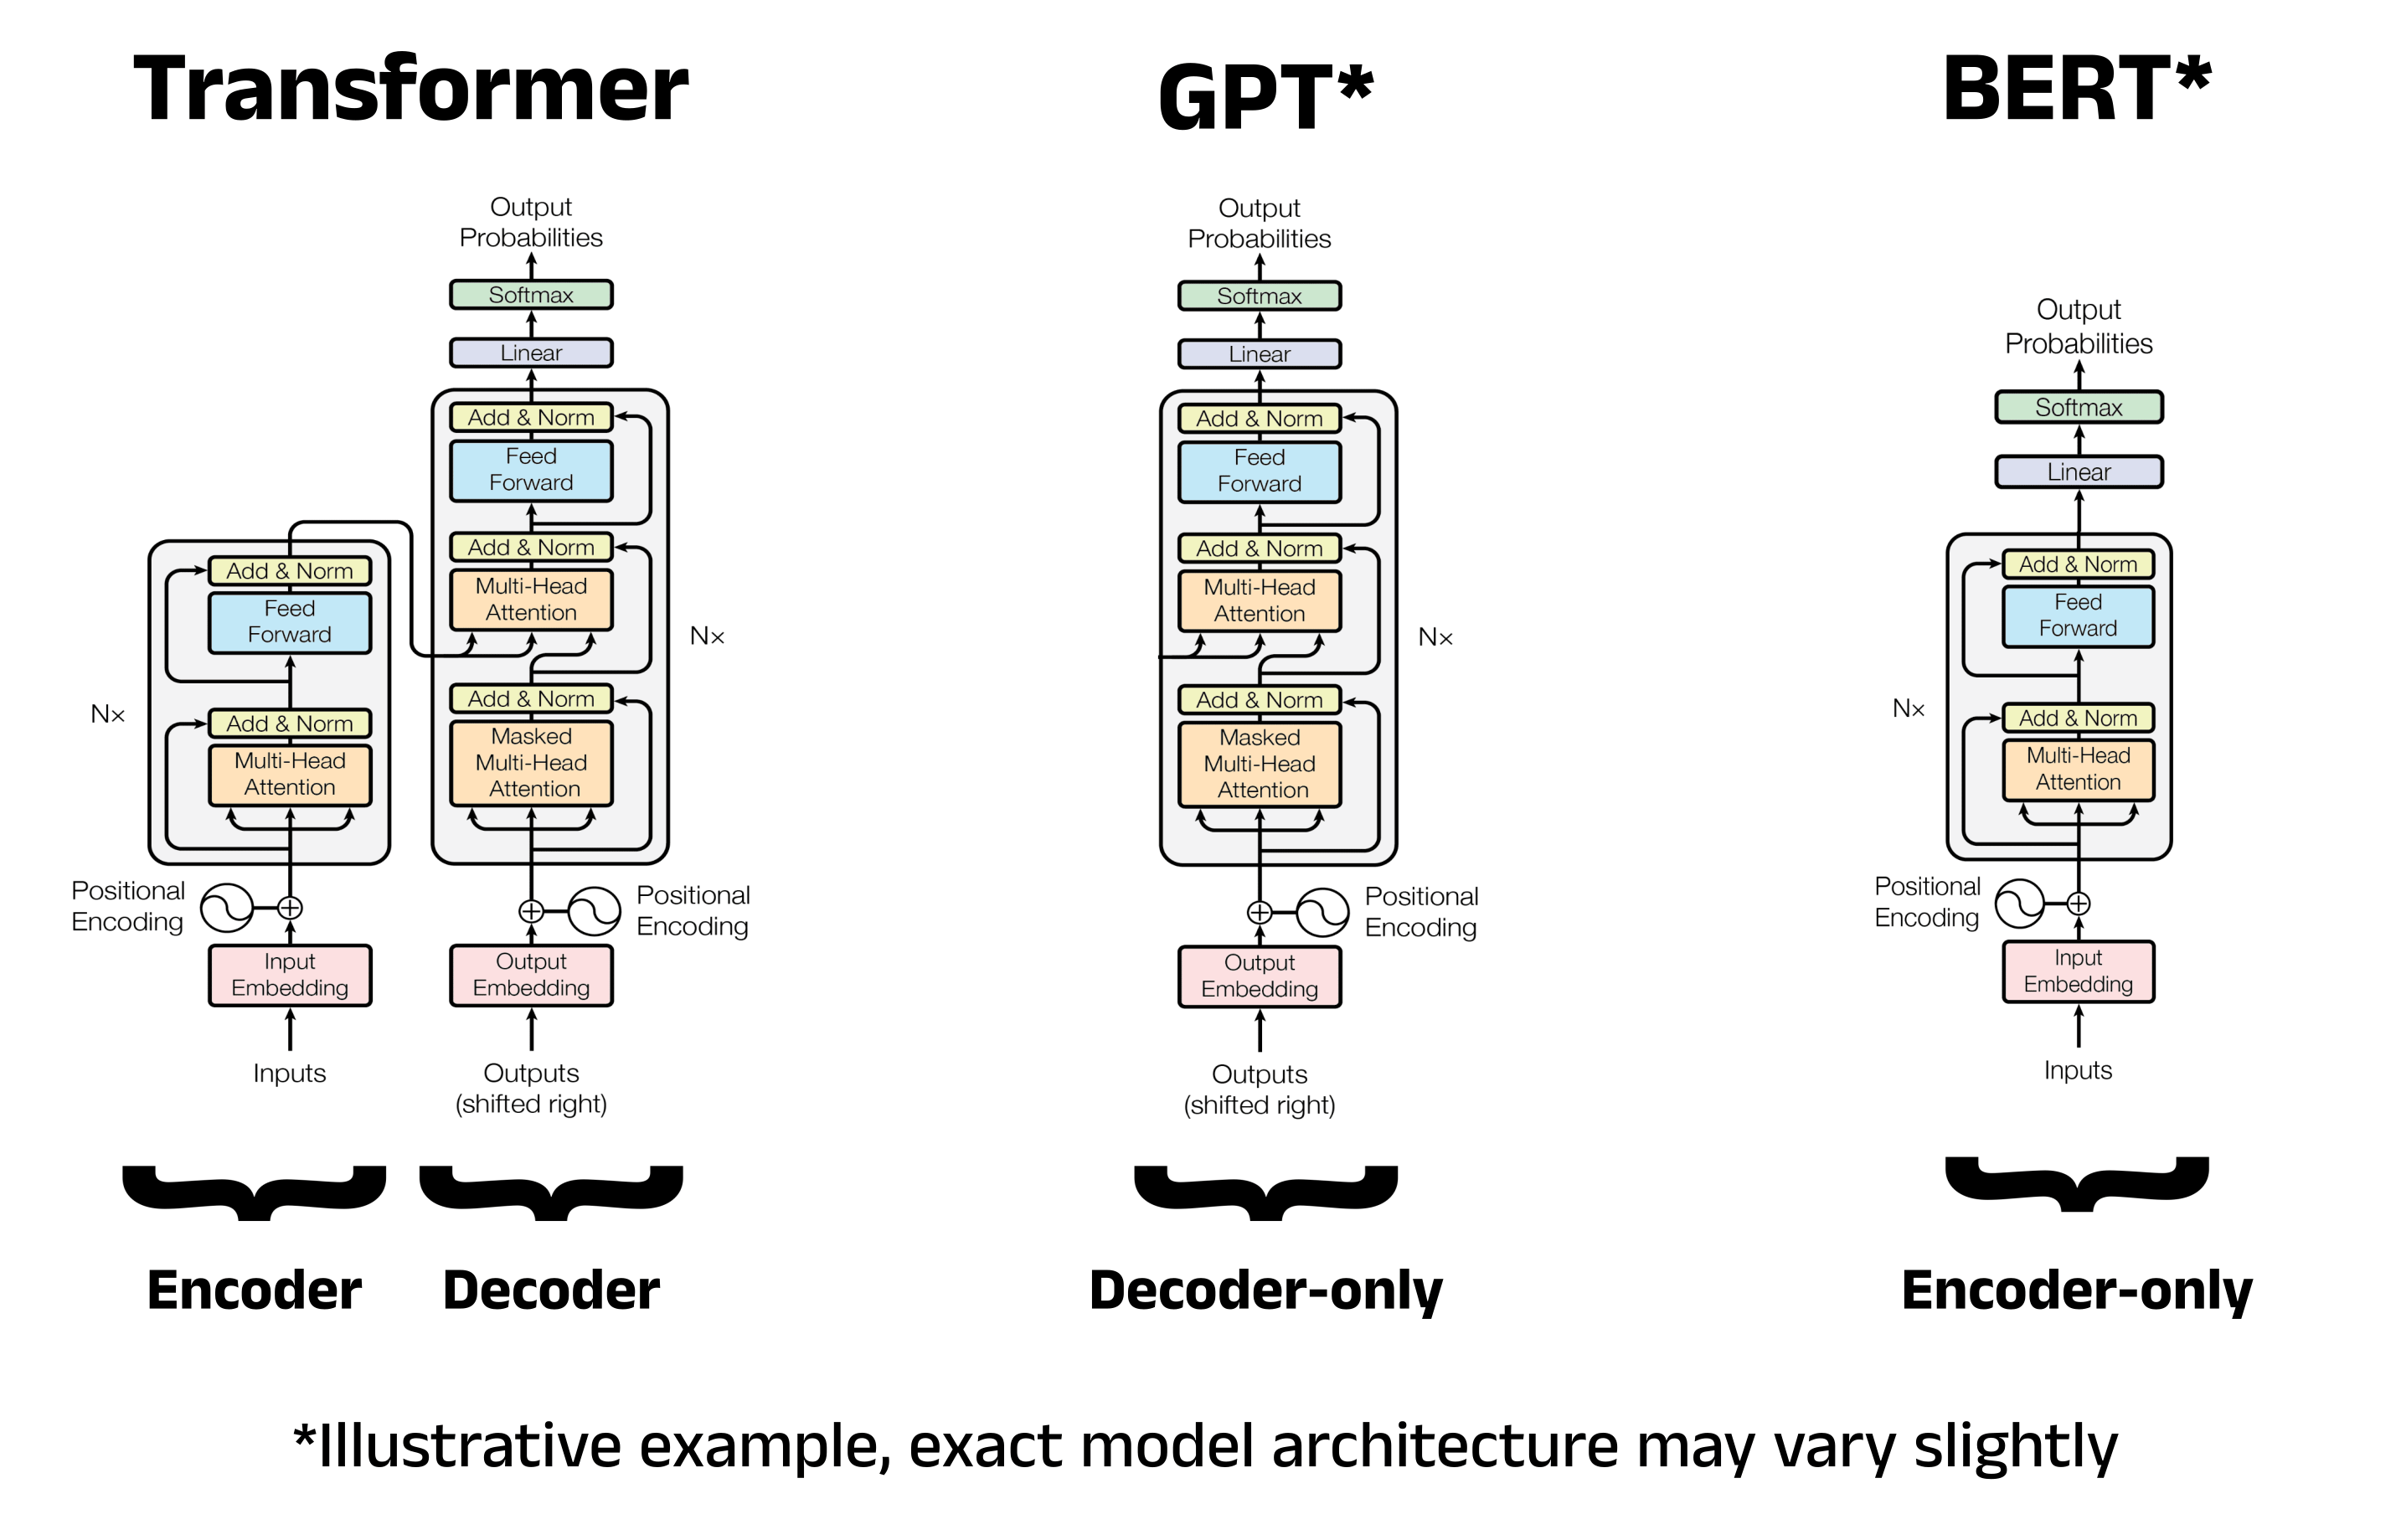

In [21]:
# Model 7: BERT-like
print("\nMODEL 7: BERT-LIKE")
print("=" * 40)
print("- Learned positional embeddings")
print("- Multiple task heads")
print("- Bidirectional training capability")

model_7 = create_model('bert_like', dataset.vocab_size, embed_dim=64,
                      num_heads=4, num_layers=3, num_classes=2)
results['BERT-like'] = train_model_simple(model_7, train_loader, val_loader)
test_sample_prediction(model_7, val_loader)


MODEL 7: BERT-LIKE
- Learned positional embeddings
- Multiple task heads
- Bidirectional training capability
Model 7 created: BERT-like (3 layers, classification + MLM heads)
Training for 6 epochs with lr=0.001
Epoch 0: Train Loss=0.5659, Train Acc=68.3% | Val Loss=0.3704, Val Acc=86.7%
Epoch 1: Train Loss=0.2165, Train Acc=93.3% | Val Loss=0.2423, Val Acc=90.0%
Epoch 2: Train Loss=0.1070, Train Acc=96.7% | Val Loss=0.6243, Val Acc=76.7%
Epoch 3: Train Loss=0.0619, Train Acc=98.3% | Val Loss=0.3406, Val Acc=90.0%
Epoch 4: Train Loss=0.0439, Train Acc=99.2% | Val Loss=0.5126, Val Acc=90.0%
Epoch 5: Train Loss=0.0096, Train Acc=100.0% | Val Loss=0.4360, Val Acc=83.3%
Sample Text: tensor([ 17,  97, 130,   1,  28, 132,   0,   0,   0,   0])
Sample Prediction: 0 (confidence: 0.998)
Actual Label: 0 (CORRECT)


# Masked language modelling - LLM pre-training

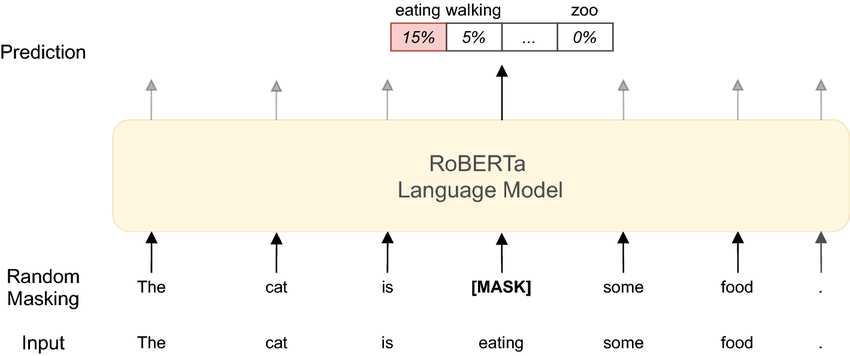